# Лабораторная работа № 1. Обработка естественного языка.


# Резюме:
1. BatchNorm и параллельные сверточные слои улучшают результат. Дополнительные слои улучшают результат значительно, но их количество не стоит бездумно увлеличивать, есть некоторый предел, который я обнаружил путем экспериментов
2. Взял базовую модель с семинара и прикрутил к ним MaxPooling и AveragePooling. MaxPooling тоже положительно сказался на эффективности модели, AveragePooling повлиял слабо
3. Взял самую удачную модель из первого задания и прикрутил к ним pretrained эмбеддинги твиттера и википедии. Эмбеддинги твиттера и википедии сильно результат не улучшили. Результаты на замороженных весах достаточно хорошие, а на предобученных не очень. Но, возможно, нужно большое количество итераций, чтобы добиться тех же результатов, что и на замороженных.
**Важно: в некоторых местах графики и результаты немного отвалились, потому что я случайно прервал сессию в колабе и все пришлось заново запускать. Но у меня время по GPU вышло, поэтому не удалось все данные восстановить. Я до дедлайна залил в том виде, в котором есть. Извините, пожалуйста, за неудобства!**

# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv("drive/My Drive/Train_rev1.csv",  index_col=None)

In [5]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

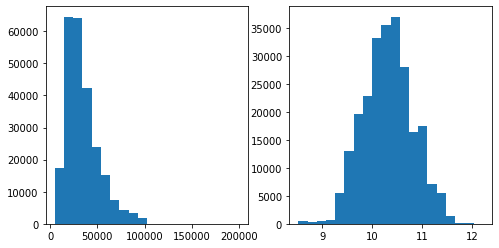

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
3171,57183345,Experienced Membership Sales Advisor Walton ...,Experienced Membership Sales Advisor Up to ***...,"Walton-on-Thames, Surrey",Walton-On-Thames,NaN,permanent,Leisurejobs Recruitment,Travel Jobs,Up to 16K basic plus commision,16000,leisurejobs.com,9.680407
119881,69891855,Seniorr Credit Risk Analyst **** North West,Senior Credit Risk Analysts **** **** depend...,Accrington Lancashire North West,Accrington,NaN,permanent,NaN,IT Jobs,50000,50000,technojobs.co.uk,10.819798
9924,66190499,Physical Health Adviser Physio,TLA currently have a exciting position for a P...,"Lincolnshire, Lincolnshire",Lincolnshire,NaN,NaN,NaN,Healthcare & Nursing Jobs,$24585 to $29895 per year,27240,careworx.co.uk,10.212479


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
import nltk
#TODO YOUR CODE HERE

tokenizer = nltk.tokenize.WordPunctTokenizer()
# YOUR CODE HERE

data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

Now we can assume that our text is a space-separated list of tokens:

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter
token_counts = Counter()
# Count how many times does each token occur in both "Title" and "FullDescription" in total
#TODO <YOUR CODE>

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [12]:
  print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


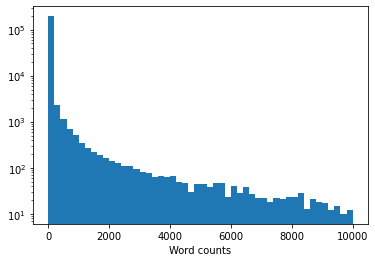

In [13]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [15]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [16]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [17]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [20]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [21]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [22]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[32937, 31100, 33664, 12587,   982, 17753, 11192,  1693,   943,  8110],
         [ 2572, 33996,   982, 13650,   158, 33554,   982,   437, 22021,    82],
         [33996, 33435, 30323, 33554,  3002, 20893, 11312,   158,  7151, 31100]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631]),
 'Title': tensor([[27645, 26986,  1587,   197, 11192,  1700],
         [27280, 13650, 30409,  2844,     1,     1],
         [ 4986,  9083, 18864,     1,     1,     1]])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [24]:
import torch
import torch.nn as nn
import torch.functional as F

In [25]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [26]:
model = SalaryPredictor()

In [27]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [28]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [29]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 3
DEVICE = torch.device('cpu')

In [30]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [ ]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 4.044020652770996
val results:
Mean square error: 2.74679
Mean absolute error: 0.81665
train_loss 0.4105803370475769
val results:
Mean square error: 0.84066
Mean absolute error: 0.43720
train_loss 0.34497150778770447
val results:
Mean square error: 0.82837
Mean absolute error: 0.43664
train_loss 0.39154142141342163
val results:
Mean square error: 0.82191
Mean absolute error: 0.43691
train_loss 0.2604941427707672
val results:
Mean square error: 0.80189
Mean absolute error: 0.43256
train_loss 0.3067243695259094
val results:
Mean square error: 0.79144
Mean absolute error: 0.43053
train_loss 0.22235235571861267
val results:
Mean square error: 0.82279
Mean absolute error: 0.44033
train_loss 0.19317923486232758
val results:
Mean square error: 0.80036
Mean absolute error: 0.43447
train_loss 0.22979065775871277
val results:
Mean square error: 0.76757
Mean absolute error: 0.42542
train_loss 0.19006413221359253
val results:
Mean square error: 0.76453
Mean absolute error: 0.42498
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1535477489233017
val results:
Mean square error: 0.70198
Mean absolute error: 0.40806
train_loss 0.13694101572036743
val results:
Mean square error: 0.69207
Mean absolute error: 0.40518
train_loss 0.14219173789024353
val results:
Mean square error: 0.69383
Mean absolute error: 0.40584
train_loss 0.12424763292074203
val results:
Mean square error: 0.69897
Mean absolute error: 0.40760
train_loss 0.18525993824005127
val results:
Mean square error: 0.69661
Mean absolute error: 0.40700
train_loss 0.1573062539100647
val results:
Mean square error: 0.66813
Mean absolute error: 0.39820
train_loss 0.1363944411277771
val results:
Mean square error: 0.66325
Mean absolute error: 0.39684
train_loss 0.16711796820163727
val results:
Mean square error: 0.67082
Mean absolute error: 0.39937
train_loss 0.17155307531356812
val results:
Mean square error: 0.62603
Mean absolute error: 0.38521
train_loss 0.1343914270401001
val results:
Mean square error: 0.67299
Mean absolute error: 0.40027
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.13524287939071655
val results:
Mean square error: 0.56889
Mean absolute error: 0.36710
train_loss 0.1449483036994934
val results:
Mean square error: 0.56798
Mean absolute error: 0.36695
train_loss 0.08344431966543198
val results:
Mean square error: 0.57519
Mean absolute error: 0.36944
train_loss 0.11568062752485275
val results:
Mean square error: 0.56731
Mean absolute error: 0.36682
train_loss 0.12030826508998871
val results:
Mean square error: 0.57001
Mean absolute error: 0.36781
train_loss 0.13749343156814575
val results:
Mean square error: 0.58015
Mean absolute error: 0.37134
train_loss 0.09000754356384277
val results:
Mean square error: 0.55914
Mean absolute error: 0.36421
train_loss 0.13163478672504425
val results:
Mean square error: 0.55619
Mean absolute error: 0.36332
train_loss 0.11550968140363693
val results:
Mean square error: 0.53854
Mean absolute error: 0.35723
train_loss 0.10541294515132904
val results:
Mean square error: 0.52399
Mean absolute error: 0.35227
t

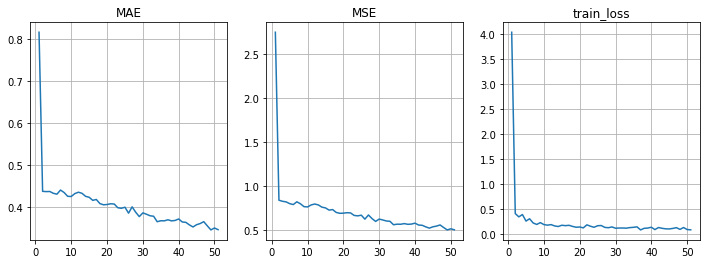

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

In [41]:
dict_5 = model.state_dict()
del dict_5['final_predictor.2.bias']
del dict_5['final_predictor.2.weight']
#сохранил параметры для задачи 5

# Задание 1 


Сначала добавим к модели с семинара BatchNorm и посмотрим на результаты

In [ ]:
class SalaryPredictorBN(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorBN().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 18.875173568725586
val results:
Mean square error: 4.02035
Mean absolute error: 0.98947
train_loss 0.7737390995025635
val results:
Mean square error: 2.24243
Mean absolute error: 0.72938
train_loss 11.722464561462402
val results:
Mean square error: 4.46788
Mean absolute error: 1.04608
train_loss 2.3428168296813965
val results:
Mean square error: 2.21772
Mean absolute error: 0.72740
train_loss 3.979811191558838
val results:
Mean square error: 1.43991
Mean absolute error: 0.57741
train_loss 1.5668871402740479
val results:
Mean square error: 1.30452
Mean absolute error: 0.54776
train_loss 0.786276638507843
val results:
Mean square error: 1.64761
Mean absolute error: 0.62282
train_loss 0.7363950610160828
val results:
Mean square error: 1.03873
Mean absolute error: 0.48431
train_loss 0.6034902930259705
val results:
Mean square error: 1.00511
Mean absolute error: 0.47592
train_loss 2.7547030448913574
val results:
Mean square error: 2.39595
Mean absolute error: 0.76005
train_loss 0

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.4739324450492859
val results:
Mean square error: 1.23834
Mean absolute error: 0.53701
train_loss 1.4221099615097046
val results:
Mean square error: 0.78474
Mean absolute error: 0.41772
train_loss 0.554452121257782
val results:
Mean square error: 1.16215
Mean absolute error: 0.51958
train_loss 0.390581876039505
val results:
Mean square error: 1.05866
Mean absolute error: 0.49446
train_loss 0.4674939811229706
val results:
Mean square error: 1.15082
Mean absolute error: 0.51769
train_loss 0.641298770904541
val results:
Mean square error: 1.12284
Mean absolute error: 0.51114
train_loss 0.563755452632904
val results:
Mean square error: 0.99002
Mean absolute error: 0.47748
train_loss 3.8706507682800293
val results:
Mean square error: 2.15781
Mean absolute error: 0.72228
train_loss 1.5286582708358765
val results:
Mean square error: 1.23631
Mean absolute error: 0.53904
train_loss 0.37159639596939087
val results:
Mean square error: 1.19445
Mean absolute error: 0.52950
train_loss 0.

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.5648093223571777
val results:
Mean square error: 1.07229
Mean absolute error: 0.50158
train_loss 0.3082546889781952
val results:
Mean square error: 1.01177
Mean absolute error: 0.48627
train_loss 0.3727648854255676
val results:
Mean square error: 1.07208
Mean absolute error: 0.50185
train_loss 0.34269535541534424
val results:
Mean square error: 0.92255
Mean absolute error: 0.46308
train_loss 0.338922917842865
val results:
Mean square error: 0.92187
Mean absolute error: 0.46304
train_loss 0.4775816798210144
val results:
Mean square error: 0.95848
Mean absolute error: 0.47299
train_loss 0.2915479838848114
val results:
Mean square error: 0.95871
Mean absolute error: 0.47321
train_loss 0.313113272190094
val results:
Mean square error: 1.02972
Mean absolute error: 0.49173
train_loss 0.31759074330329895
val results:
Mean square error: 0.94965
Mean absolute error: 0.47104
train_loss 0.26763176918029785
val results:
Mean square error: 1.04756
Mean absolute error: 0.49646
train_los

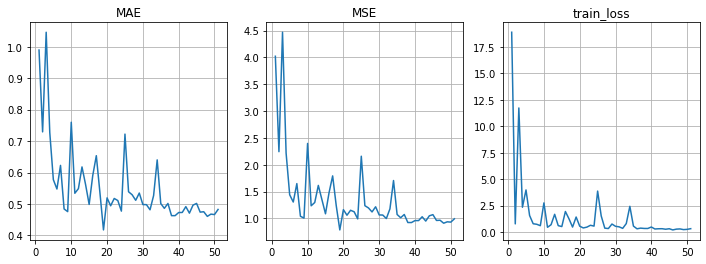

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Теперь попробуем использовать параллельные слои

In [ ]:
class SalaryPredictorBNAndParallel(nn.Module): # BatchNorm1d, 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat([title_features0, title_features1], dim=1)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorBNAndParallel().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }
eps = 10**(-3)
flag = 1

for epoch in range(EPOCHS):
  if flag:
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
      if flag:
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.7558400630950928
val results:
Mean square error: 0.83831
Mean absolute error: 0.42271
train_loss 0.6041058301925659
val results:
Mean square error: 0.82990
Mean absolute error: 0.42356
train_loss 0.6642873287200928
val results:
Mean square error: 0.78418
Mean absolute error: 0.41238
train_loss 0.550929069519043
val results:
Mean square error: 0.81635
Mean absolute error: 0.42403
train_loss 0.6172729134559631
val results:
Mean square error: 0.77321
Mean absolute error: 0.41249
train_loss 0.4269559979438782
val results:
Mean square error: 0.77640
Mean absolute error: 0.41468
train_loss 0.5416563749313354
val results:
Mean square error: 0.81682
Mean absolute error: 0.42784
train_loss 0.42405447363853455
val results:
Mean square error: 0.79828
Mean absolute error: 0.42335
train_loss 0.33163297176361084
val results:
Mean square error: 0.79365
Mean absolute error: 0.42284
train_loss 0.3454694151878357
val results:
Mean square error: 0.78727
Mean absolute error: 0.42163
train_los

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.3403721749782562
val results:
Mean square error: 0.79425
Mean absolute error: 0.42625
train_loss 0.2870899438858032
val results:
Mean square error: 0.78696
Mean absolute error: 0.42428
train_loss 0.31934499740600586
val results:
Mean square error: 0.81803
Mean absolute error: 0.43350
train_loss 0.27501216530799866
val results:
Mean square error: 0.80079
Mean absolute error: 0.42864
train_loss 0.24655382335186005
val results:
Mean square error: 0.80792
Mean absolute error: 0.43086
train_loss 0.24281644821166992
val results:
Mean square error: 0.80458
Mean absolute error: 0.43001
train_loss 0.31984445452690125
val results:
Mean square error: 0.81856
Mean absolute error: 0.43417
train_loss 0.3200368285179138
val results:
Mean square error: 0.79124
Mean absolute error: 0.42633
train_loss 0.31203538179397583
val results:
Mean square error: 0.76932
Mean absolute error: 0.41994
train_loss 0.2862500548362732
val results:
Mean square error: 0.84210
Mean absolute error: 0.44117
trai

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.3368718922138214
val results:
Mean square error: 0.79340
Mean absolute error: 0.42767
train_loss 0.2828477621078491
val results:
Mean square error: 0.81454
Mean absolute error: 0.43385
train_loss 0.2576470673084259
val results:
Mean square error: 0.82234
Mean absolute error: 0.43614
train_loss 0.28250688314437866
val results:
Mean square error: 0.78456
Mean absolute error: 0.42522
train_loss 0.23986202478408813
val results:
Mean square error: 0.82291
Mean absolute error: 0.43639
train_loss 0.2624528706073761
val results:
Mean square error: 0.81010
Mean absolute error: 0.43274
train_loss 0.25007155537605286
val results:
Mean square error: 0.80464
Mean absolute error: 0.43120
train_loss 0.26890620589256287
val results:
Mean square error: 0.79319
Mean absolute error: 0.42790
train_loss 0.2854500412940979
val results:
Mean square error: 0.81218
Mean absolute error: 0.43344
train_loss 0.23263674974441528
val results:
Mean square error: 0.81578
Mean absolute error: 0.43452
train

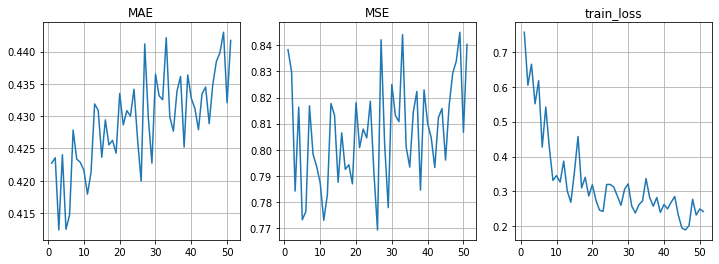

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Теперь соберем модель с BatchNorm, параллельными сверточными слоями и дополнительными слоями

In [ ]:
class SalaryPredictorUltimate(nn.Module): 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size*2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat(
            [title_features0, title_features1], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorUltimate().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
lambda1 = lambda epoch: 0.3 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }
eps = 10**(-3)
flag = 1

for epoch in range(EPOCHS):
  if flag:
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
      if flag:
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))

          scheduler.step()
          if (i > 198) and abs(metrics['MSE'][-1][1] - metrics['MSE'][-2][1]) < eps:
            print(i, abs(metrics['MSE'][-1][1] - metrics['MSE'][-2][1]))
            flag = 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.5072399377822876
val results:
Mean square error: 0.22042
Mean absolute error: 0.19959
train_loss 0.3492266535758972
val results:
Mean square error: 0.30345
Mean absolute error: 0.24399
train_loss 0.31613123416900635
val results:
Mean square error: 0.30478
Mean absolute error: 0.24516
train_loss 0.3376038074493408
val results:
Mean square error: 0.30276
Mean absolute error: 0.24407
train_loss 0.4645034074783325
val results:
Mean square error: 0.28634
Mean absolute error: 0.23638
train_loss 0.37264934182167053
val results:
Mean square error: 0.30899
Mean absolute error: 0.24708
train_loss 0.31917116045951843
val results:
Mean square error: 0.28695
Mean absolute error: 0.23671
train_loss 0.3744964897632599
val results:
Mean square error: 0.30397
Mean absolute error: 0.24484
train_loss 0.2697834372520447
val results:
Mean square error: 0.32051
Mean absolute error: 0.25250
train_loss 0.2737653851509094
val results:
Mean square error: 0.28409
Mean absolute error: 0.23518
train_l

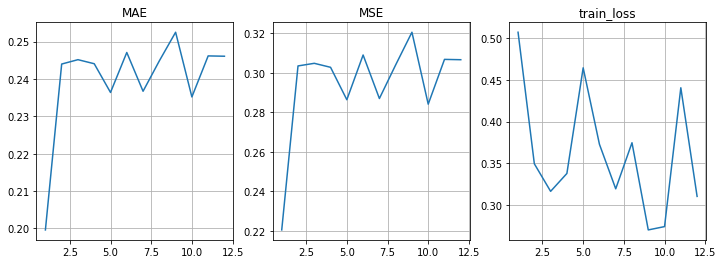

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Добавление дополнительных слоев действительно сильно улучшило результаты (однако слои можно увеличивать до определенного момента, модели с большим количеством слоев эффективности не показывали). Комбинирование BN и параллельных сверточных слоев тоже изменило результаты к лучшему. Но сложилось впечатление, что использование BN не сильно повышает качество моделей для NLP задач

# Задание 2


Pooling layer нужен для уменьшения размерности, что бывает полезно в условиях ограниченной вычислительной мощности. Обычно он расположен после сверточного слоя. Он также позволяет извлечь доминирующие признаки и подавить шумы.

Возьмем базовую модель с семинара и добавим MaxPooling:

In [ ]:
class SalaryPredictorMaxPool(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        #  YOUR CODE HERE

        
    def forward(self, batch):
        # YOUR CODE HERE
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorMaxPool().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 42.40117645263672
val results:
Mean square error: 12.11189
Mean absolute error: 1.73564
train_loss 0.5164247155189514
val results:
Mean square error: 0.63089
Mean absolute error: 0.36888
train_loss 0.47962692379951477
val results:
Mean square error: 0.56780
Mean absolute error: 0.35087
train_loss 0.27444717288017273
val results:
Mean square error: 0.55652
Mean absolute error: 0.35019
train_loss 0.2955152094364166
val results:
Mean square error: 0.54508
Mean absolute error: 0.34955
train_loss 0.27765533328056335
val results:
Mean square error: 0.52688
Mean absolute error: 0.34459
train_loss 0.24659216403961182
val results:
Mean square error: 0.51871
Mean absolute error: 0.34287
train_loss 0.24390025436878204
val results:
Mean square error: 0.50746
Mean absolute error: 0.33968
train_loss 0.21138039231300354
val results:
Mean square error: 0.49907
Mean absolute error: 0.33741
train_loss 0.18082915246486664
val results:
Mean square error: 0.52730
Mean absolute error: 0.34823
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1421794444322586
val results:
Mean square error: 0.35375
Mean absolute error: 0.28259
train_loss 0.14993561804294586
val results:
Mean square error: 0.34229
Mean absolute error: 0.27766
train_loss 0.10331010073423386
val results:
Mean square error: 0.32765
Mean absolute error: 0.27118
train_loss 0.11682543903589249
val results:
Mean square error: 0.29572
Mean absolute error: 0.25631
train_loss 0.16300758719444275
val results:
Mean square error: 0.26579
Mean absolute error: 0.24155
train_loss 0.12491220980882645
val results:
Mean square error: 0.26758
Mean absolute error: 0.24271
train_loss 0.11113676428794861
val results:
Mean square error: 0.28540
Mean absolute error: 0.25167
train_loss 0.12020929902791977
val results:
Mean square error: 0.25831
Mean absolute error: 0.23806
train_loss 0.09305740147829056
val results:
Mean square error: 0.26045
Mean absolute error: 0.23927
train_loss 0.12034708261489868
val results:
Mean square error: 0.24120
Mean absolute error: 0.22919
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.16097614169120789
val results:
Mean square error: 0.22927
Mean absolute error: 0.22362
train_loss 0.12377616763114929
val results:
Mean square error: 0.20819
Mean absolute error: 0.21179
train_loss 0.1138412207365036
val results:
Mean square error: 0.23091
Mean absolute error: 0.22468
train_loss 0.13292691111564636
val results:
Mean square error: 0.24967
Mean absolute error: 0.23492
train_loss 0.12965460121631622
val results:
Mean square error: 0.23387
Mean absolute error: 0.22659
train_loss 0.12144673615694046
val results:
Mean square error: 0.22134
Mean absolute error: 0.21993
train_loss 0.12231890112161636
val results:
Mean square error: 0.23643
Mean absolute error: 0.22827
train_loss 0.09865015745162964
val results:
Mean square error: 0.26878
Mean absolute error: 0.24526
train_loss 0.11289800703525543
val results:
Mean square error: 0.25706
Mean absolute error: 0.23939
train_loss 0.10855300724506378
val results:
Mean square error: 0.25961
Mean absolute error: 0.24089
t

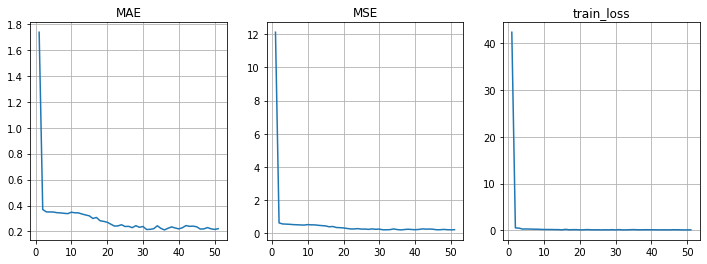

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Теперь сделаем с AvearagePooling:

In [ ]:
class SalaryPredictorAvgPool(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AvgPool1d(2, count_include_pad=False),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AvgPool1d(2, count_include_pad=False),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()


In [ ]:
model = SalaryPredictorAvgPool().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 28.753536224365234
val results:
Mean square error: 8.96320
Mean absolute error: 1.49105
train_loss 0.48200440406799316
val results:
Mean square error: 0.74690
Mean absolute error: 0.40495
train_loss 0.32211846113204956
val results:
Mean square error: 0.73457
Mean absolute error: 0.40358
train_loss 0.520772397518158
val results:
Mean square error: 0.68290
Mean absolute error: 0.38947
train_loss 0.5361063480377197
val results:
Mean square error: 0.69536
Mean absolute error: 0.39515
train_loss 0.40409937500953674
val results:
Mean square error: 0.68504
Mean absolute error: 0.39332
train_loss 0.30374181270599365
val results:
Mean square error: 0.68831
Mean absolute error: 0.39552
train_loss 0.35655736923217773
val results:
Mean square error: 0.61849
Mean absolute error: 0.37396
train_loss 0.28847479820251465
val results:
Mean square error: 0.67063
Mean absolute error: 0.39205
train_loss 0.2628657817840576
val results:
Mean square error: 0.61329
Mean absolute error: 0.37424
train

RuntimeError: ignored

In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Avearge Pooling результат не улучшает, а Max Pooling повышает эффективность модели

Задание 3

Здесь возьмем самую удачную модель из первого номера и прикрутим pretrained эмбеддинги. Сначала обучим на рандомных весах, потом на замороженных. И сравним.

In [ ]:
import gensim.downloader as gensim
import torch 
emb_model = gensim.load('glove-twitter-100')
weights = torch.FloatTensor(emb_model.vectors)
embedding = nn.Embedding.from_pretrained(weights)
embedding(batch['Title']).permute(0, 2, 1).shape

In [ ]:
class SalaryPredictorUltimateTwitter(nn.Module): 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        weights = torch.FloatTensor(emb_model.vectors)
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=False)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size*2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat(
            [title_features0, title_features1], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorUltimateTwitter().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(2):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Теперь заморозим веса для Твиттера

In [ ]:
class SalaryPredictorUltimateTwitterFrozen(nn.Module): 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        weights = torch.FloatTensor(emb_model.vectors)
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=True)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size*2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat(
            [title_features0, title_features1], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorUltimateTwitterFrozen().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(2):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Теперь та же схема, но с википедией

In [ ]:
import gensim.downloader as gensim
emb_model = gensim.load('glove-wiki-gigaword-100')
weights = torch.FloatTensor(emb_model.vectors)
embedding = nn.Embedding.from_pretrained(weights)

In [ ]:
class SalaryPredictorUltimateWiki(nn.Module): 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        weights = torch.FloatTensor(emb_model.vectors)
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=False)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size*2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat(
            [title_features0, title_features1], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorUltimateWiki().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(2):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

Заморозим веса для Википедии

In [ ]:
class SalaryPredictorUltimateWikiFrozen(nn.Module): 
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        weights = torch.FloatTensor(emb_model.vectors)
        self.embedder = nn.Embedding.from_pretrained(weights, freeze=True)
        self.title_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.title_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )

        self.description_encoder0 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 4),
            nn.ReLU(),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 6, hid_size*2),
            nn.ReLU(),
            nn.Linear(hid_size*2, 1)
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features0 = self.title_encoder0(title_embeddings).squeeze()
        title_features1 = self.title_encoder1(title_embeddings).squeeze()
        title_features = torch.cat(
            [title_features0, title_features1], dim=1)


        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features0 = self.description_encoder0(description_embeddings).squeeze()
        description_features1 = self.description_encoder1(description_embeddings).squeeze()
        description_features = torch.cat(
            [description_features0, description_features1], dim=1)
                
        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [ ]:
model = SalaryPredictorUltimateWikiFrozen().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(2):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))


In [ ]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

На предобученных эмбеддингах результаты разительно лучше не стали и сильно не отличаются. К сожалению, мощности сильно не хватало для обучения, поэтому много разных гипотез проверить не удалось. В целом, кажется, что на замороженных весах результат получился лучше, но на незамороженных, я думаю, можно получить такой же результат при большем количестве итераций (как раз-таки чтобы эту гипотезу проверить надо больше мощности и времени)

# Задание 4

In [31]:
from torch.autograd import Variable

In [32]:
class RNN_GRU(nn.Module):
    def __init__(self, n_tokens=35000, n_cat_features=50, hid_size=8, bidirectional=False):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25))
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25))
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.GRU = nn.GRU(input_size=8,hidden_size=8, bidirectional=bidirectional)
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        if bidirectional:
            number_input = 7
        else:
            number_input = 6
        self.categorical_encoder = nn.Sequential(
            nn.Linear(3768, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * (number_input), hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        
        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()
        
        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_embeddings_conv = description_embeddings.permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings_conv).squeeze()
        
        gru_out, hidden = self.GRU(description_embeddings)
        title_gru_features = self.pool3(gru_out.permute(0, 2, 1)).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, description_features, title_gru_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [33]:
EPOCHS=2

model = RNN_GRU().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 2.909240245819092
val results:
Mean square error: 1.26208
Mean absolute error: 0.39245
train_loss 3.037534713745117
val results:
Mean square error: 0.83242
Mean absolute error: 0.32011
train_loss 1.3981117010116577
val results:
Mean square error: 0.45629
Mean absolute error: 0.24347
train_loss 1.0386953353881836
val results:
Mean square error: 0.33428
Mean absolute error: 0.21798
train_loss 0.7549393177032471
val results:
Mean square error: 0.23996
Mean absolute error: 0.18836
train_loss 0.4602406322956085
val results:
Mean square error: 0.23685
Mean absolute error: 0.19505
train_loss 0.39421379566192627
val results:
Mean square error: 0.20822
Mean absolute error: 0.18542
train_loss 0.3714928925037384
val results:
Mean square error: 0.21038
Mean absolute error: 0.19146
train_loss 0.3079318404197693
val results:
Mean square error: 0.17831
Mean absolute error: 0.17583
train_loss 0.21943135559558868
val results:
Mean square error: 0.18748
Mean absolute error: 0.18426
train_loss

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.16995856165885925
val results:
Mean square error: 0.14437
Mean absolute error: 0.16558
train_loss 0.16603504121303558
val results:
Mean square error: 0.13386
Mean absolute error: 0.15863
train_loss 0.1289922446012497
val results:
Mean square error: 0.13115
Mean absolute error: 0.15710
train_loss 0.13012844324111938
val results:
Mean square error: 0.11791
Mean absolute error: 0.14755
train_loss 0.18269619345664978
val results:
Mean square error: 0.13128
Mean absolute error: 0.15794
train_loss 0.1709214746952057
val results:
Mean square error: 0.11702
Mean absolute error: 0.14740
train_loss 0.12083183228969574
val results:
Mean square error: 0.11757
Mean absolute error: 0.14811
train_loss 0.14350685477256775
val results:
Mean square error: 0.13421
Mean absolute error: 0.16050
train_loss 0.12248595058917999
val results:
Mean square error: 0.12822
Mean absolute error: 0.15683
train_loss 0.1246231198310852
val results:
Mean square error: 0.11758
Mean absolute error: 0.14889
tra

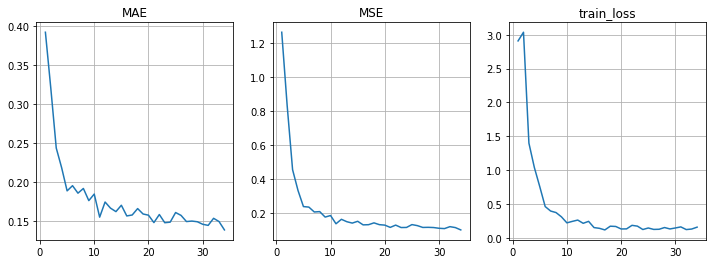

In [36]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

# Двунаправленная

In [37]:
class RNN_GRU2(nn.Module):
    def __init__(self, n_tokens=35000, n_cat_features=50, hid_size=8, bidirectional=True):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.conv1 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=3),
            nn.Dropout(p=0.25))
        self.pool1 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25))
        self.pool2 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.GRU = nn.GRU(input_size=8,hidden_size=8, bidirectional=bidirectional)
        self.pool3 = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        if bidirectional:
            number_input = 7
        else:
            number_input = 6
        self.categorical_encoder = nn.Sequential(
            nn.Linear(3768, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * (number_input), hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        
        title_conv_features1 = self.conv1(title_embeddings)
        title_features1 = self.pool1(title_conv_features1).squeeze()
        
        title_conv_features2 = self.conv2(title_embeddings)
        title_features2 = self.pool2(title_conv_features2).squeeze()

        description_embeddings = self.embedder(batch['FullDescription'])
        description_embeddings_conv = description_embeddings.permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings_conv).squeeze()
        
        gru_out, hidden = self.GRU(description_embeddings)
        title_gru_features = self.pool3(gru_out.permute(0, 2, 1)).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'].float())

        features = torch.cat(
            [title_features1, title_features2, description_features, title_gru_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [40]:
EPOCHS=2

model = RNN_GRU2().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

metrics = {'train_loss': [], 'MSE': [], 'MAE': [] }

for epoch in range(EPOCHS):
    for i, batch in tqdm.notebook.tqdm(enumerate(
            iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE, 
                    device=DEVICE)), 
                total=len(data_train) // BATCH_SIZE
        ):
        step = len(metrics['train_loss']) + 1
        model.train()
        pred = model(batch)
        optimizer.zero_grad()
        loss = criterion(pred, batch[TARGET_COLUMN])
        loss.backward()
        optimizer.step()
        if i % 100 == 99:
          print('train_loss', loss.item())
          metrics['train_loss'].append((step, loss.item()))
          mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
          metrics['MSE'].append((step, mse))
          metrics['MAE'].append((step, mae))

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.8465204834938049
val results:
Mean square error: 0.31679
Mean absolute error: 0.22303
train_loss 0.45522281527519226
val results:
Mean square error: 0.39053
Mean absolute error: 0.27133
train_loss 0.4175073802471161
val results:
Mean square error: 0.37894
Mean absolute error: 0.27625
train_loss 0.28944432735443115
val results:
Mean square error: 0.39150
Mean absolute error: 0.28721
train_loss 0.23013517260551453
val results:
Mean square error: 0.37896
Mean absolute error: 0.28480
train_loss 0.23661409318447113
val results:
Mean square error: 0.36385
Mean absolute error: 0.27991
train_loss 0.22573032975196838
val results:
Mean square error: 0.30911
Mean absolute error: 0.25581
train_loss 0.24197044968605042
val results:
Mean square error: 0.35543
Mean absolute error: 0.27819
train_loss 0.239900603890419
val results:
Mean square error: 0.34066
Mean absolute error: 0.27231
train_loss 0.1990290880203247
val results:
Mean square error: 0.33755
Mean absolute error: 0.27140
train

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12190912663936615
val results:
Mean square error: 0.25797
Mean absolute error: 0.23553
train_loss 0.13750983774662018
val results:
Mean square error: 0.28080
Mean absolute error: 0.24770
train_loss 0.15165254473686218
val results:
Mean square error: 0.24697
Mean absolute error: 0.23040
train_loss 0.18983206152915955
val results:
Mean square error: 0.23797
Mean absolute error: 0.22582
train_loss 0.14931374788284302
val results:
Mean square error: 0.23621
Mean absolute error: 0.22517
train_loss 0.17209693789482117
val results:
Mean square error: 0.20539
Mean absolute error: 0.20797
train_loss 0.12230381369590759
val results:
Mean square error: 0.25657
Mean absolute error: 0.23657
train_loss 0.15702077746391296
val results:
Mean square error: 0.21001
Mean absolute error: 0.21118
train_loss 0.15206177532672882
val results:
Mean square error: 0.19992
Mean absolute error: 0.20557
train_loss 0.18363416194915771
val results:
Mean square error: 0.20100
Mean absolute error: 0.20636


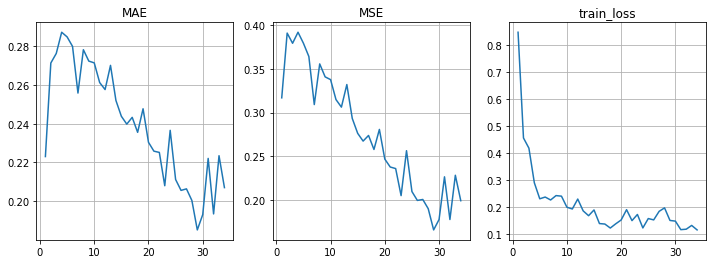

In [42]:
plt.figure(figsize=(12,4))
for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(*zip(*history))
      plt.grid()
plt.show()

# Задание 5

In [34]:
class SalaryPredictorForTrees(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU()
        )

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [35]:
new_model = SalaryPredictorForTrees()
new_model.state_dict()

OrderedDict([('embedder.weight',
              tensor([[-0.5788, -0.3789, -0.5994,  ...,  1.2006, -0.0357,  0.3622],
                      [ 0.5970,  0.7475,  0.7311,  ..., -0.7864, -0.7932,  0.0731],
                      [ 0.5860, -1.6969, -1.5434,  ...,  0.0204, -0.1826, -0.8286],
                      ...,
                      [ 0.5166,  1.4836,  0.2666,  ..., -0.2074, -0.0547,  0.5501],
                      [ 0.8579,  0.5609, -0.4015,  ...,  0.7657,  0.5857,  0.3833],
                      [ 1.0692,  0.8554, -1.1447,  ..., -0.9228,  0.7870, -0.8865]])),
             ('title_encoder.0.weight', tensor([[[-0.1910, -0.2360],
                       [-0.1758,  0.0456],
                       [ 0.0984, -0.1339],
                       [ 0.2463, -0.1209],
                       [ 0.0195,  0.0020],
                       [-0.2020, -0.0747],
                       [-0.1543,  0.1673],
                       [-0.0757,  0.1862]],
              
                      [[-0.1098,  0.2203],
    